In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix
from sklearn import manifold
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image, display_png
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
import numpy as np
from sklearn import manifold
import folium
from pyproj import Proj, transform
from pyproj import Transformer
import os
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
sns.set()

In [2]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

<h1> Objective </h1>
<blockquote>
    
Use K-Means clustering to cluster whisky distilleries by their tasting profile. Use the elbow or silhouette method to find the optimal number of clusters.
    
</blockquote>

<h2> Loading in dataset </h2>


In [3]:
whiskey_df = pd.read_csv('data/whisky.csv')

<h2> Examining the dataset </h2>


In [4]:
whiskey_df.head()

,RowID,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude
0,1,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,\tPH15 2EB,286580,749680
1,2,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,\tAB38 9PJ,326340,842570
2,3,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,\tAB5 5LI,352960,839320
3,4,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,\tPA42 7EB,141560,646220
4,5,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,\tAB54 4NH,355350,829140


<blockquote>
    From the above table we can see that we are given different attributes related to taste(body, sweetness, smoky, medicinal, tabacco, honey, picy, winey, nutty, malty, fruity, floral) and the location at which it's made. I will use these features to identify the simiarities between these whiskeys and place them in clusters.
    </blockquote>

In [5]:
whiskey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RowID       86 non-null     int64 
 1   Distillery  86 non-null     object
 2   Body        86 non-null     int64 
 3   Sweetness   86 non-null     int64 
 4   Smoky       86 non-null     int64 
 5   Medicinal   86 non-null     int64 
 6   Tobacco     86 non-null     int64 
 7   Honey       86 non-null     int64 
 8   Spicy       86 non-null     int64 
 9   Winey       86 non-null     int64 
 10  Nutty       86 non-null     int64 
 11  Malty       86 non-null     int64 
 12  Fruity      86 non-null     int64 
 13  Floral      86 non-null     int64 
 14  Postcode    86 non-null     object
 15  Latitude    86 non-null     int64 
 16  Longitude   86 non-null     int64 
dtypes: int64(15), object(2)
memory usage: 11.5+ KB


In [6]:
whiskey_df.isnull().sum()

RowID         0
Distillery    0
Body          0
Sweetness     0
Smoky         0
Medicinal     0
Tobacco       0
Honey         0
Spicy         0
Winey         0
Nutty         0
Malty         0
Fruity        0
Floral        0
Postcode      0
Latitude      0
Longitude     0
dtype: int64

<blockquote>
The data does not contain any null or incorrect value and can be used to model.
</blockquote>

<h2> Data Processing </h2>


In [7]:
whiskey_df.drop(['RowID',],inplace=True,axis=1)

<blockquote>
    Dropping RowID as I don't need it in order to model.
</blockquote>

<h2> Feature Selection </h2>


In [8]:
features = whiskey_df[['Body', 'Sweetness', 'Smoky', 'Medicinal', 'Tobacco', 
                'Honey', 'Spicy', 'Winey', 'Nutty', 'Malty', 'Fruity', 'Floral']].values

In [9]:
distortions = []
clusters = range(1,20)
for cluster in clusters:
    kmeanModel = KMeans(n_clusters=cluster, random_state=1)
    kmeanModel.fit(features)
    distortions.append(kmeanModel.inertia_)

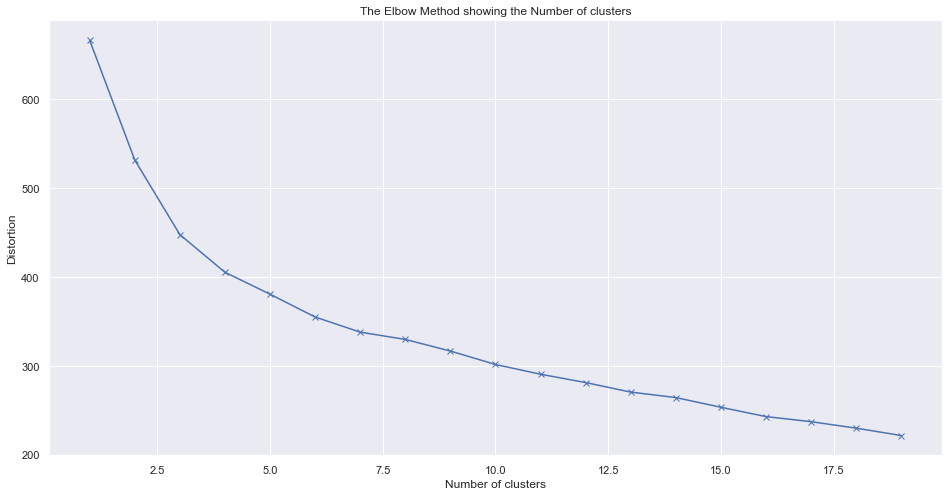

In [10]:
plt.figure(figsize=(16,8))
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the Number of clusters')
plt.show()

<blockquote>
Looking at this graph it no quite clear as to what the optimal number of clusters are
</blockquote>

In [11]:
kl = KneeLocator(
range(1, 20), distortions, curve="convex", direction="decreasing"
)

kl.elbow

6

<blockquote>
I used the kneelocator to help me identify how many clusters I should use.
</blockquote>

In [12]:
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans

KMeans(n_clusters=6, random_state=1)

In [13]:
kmodel = kmeans.fit_predict(features)


In [14]:
whiskey_df['class'] = kmodel
whiskey_df['class'].value_counts()

5    26
4    22
0    14
1    13
2     6
3     5
Name: class, dtype: int64

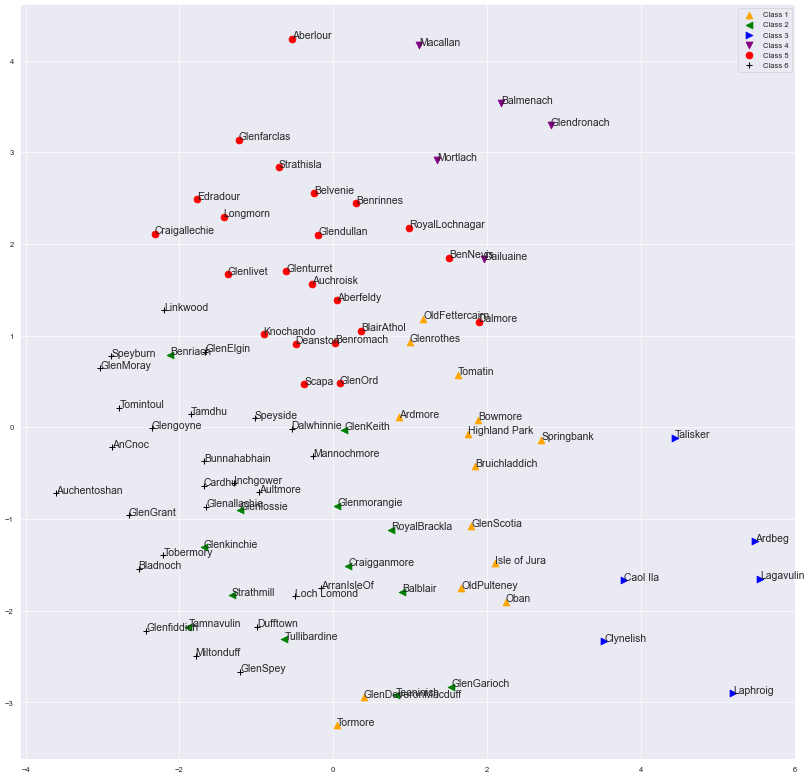

In [15]:
mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=0)
pos = mds.fit_transform(features)

col =['orange','green', 'blue', 'purple', 'red','black']
chars = "^<>vo+d"
c_flag = 0
labels = whiskey_df['Distillery']

plt.figure(figsize=(20, 20), dpi=50)
plt.rcParams["font.size"] = 15

for label, x, y, c in zip(labels, pos[:, 0], pos[:, 1],whiskey_df['class']):

    if(c == c_flag):
        c_flag = c_flag+1
        plt.scatter(x,y, c=col[c], marker=chars[c], s=100, label = "Class "+ str(c+1))
    else:
        plt.scatter(x,y, c=col[c], marker=chars[c], s=100)
        
    plt.annotate(label,xy = (x, y))
plt.legend(loc='upper right')
plt.show()

<blockquote>
From this we can see that distilleries within the same class are very closely positioned
    </blockquote>

In [16]:
map_whisky = folium.Map(location=[57.499520,  -2.776390], zoom_start = 10)

transformer = Transformer.from_crs('epsg:27700','epsg:4326')

for label, lon, lat, c in zip(labels, whiskey_df['Latitude'], whiskey_df['Longitude'], whiskey_df['class']):
    
    lat2,lon2 = transformer.transform(lon,lat)
    folium.Marker([lat2,lon2], popup= label, icon=folium.Icon(color=col[c])).add_to(map_whisky)

map_whisky

<blockquote>
    This graph shows the location of distilleries for each class. By clicking the markers, you can see the name of distilleries. From what we can see here the location doesn't have much of an impact on the type of whiskey.
    </blockquote>

<h2> Decision Tree </h2>
<blockquote>
    I'll be using a decision tree to identify the main differences between each cluster.
    </blockquote>

In [17]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state =1, min_samples_leaf=5)

X_train = features
y_train = whiskey_df['class']

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=1)

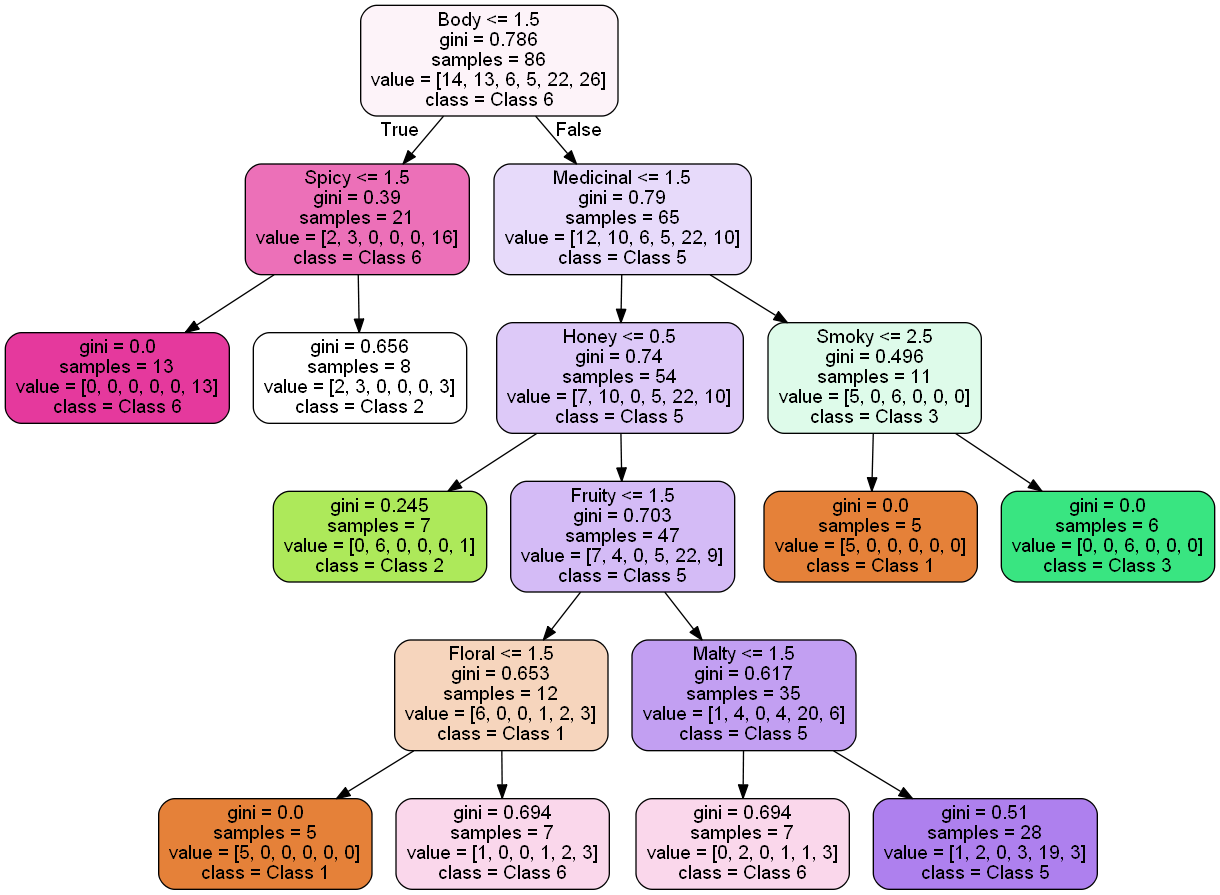

In [18]:
dot_data = export_graphviz(tree, filled = True, rounded = True, class_names = ['Class 1','Class 2', 'Class 3', 'Class 4', 'Class 5','Class 6'],
                          feature_names = ['Body', 'Sweetness', 'Smoky', 'Medicinal', 'Tobacco', 
                'Honey', 'Spicy', 'Winey', 'Nutty', 'Malty', 'Fruity', 'Floral'], out_file = None)

graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')
display_png(Image('tree.png'))

<blockquote>
    <ul>
<li> Class 1: Most of them are Body and Medicinal. Some being fruity and Honey</li>
 <li> Class 2: Most of them are Body, Medicinal and Honey.</li>
 <li> Class 3: Are body, medicinal and smokey.</li>
 <li> Class 4: Has and equal amount of samples that are Body Medicinal, Honey and Fruitty</li>
 <li> Class 5: Are Body Medicinal, Honey, Fruitty and Malty</li>
 <li> Class 6: Are mostly Body</li>
    </ul>
    </blockquote>

<h2> Silhouette Analysis to report on how successful clustering was </h2>

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.2934861103669283
For n_clusters = 3 The average silhouette_score is : 0.16276363822543338
For n_clusters = 4 The average silhouette_score is : 0.15426774332597973
For n_clusters = 5 The average silhouette_score is : 0.13310569708684986
For n_clusters = 6 The average silhouette_score is : 0.12118505751329063


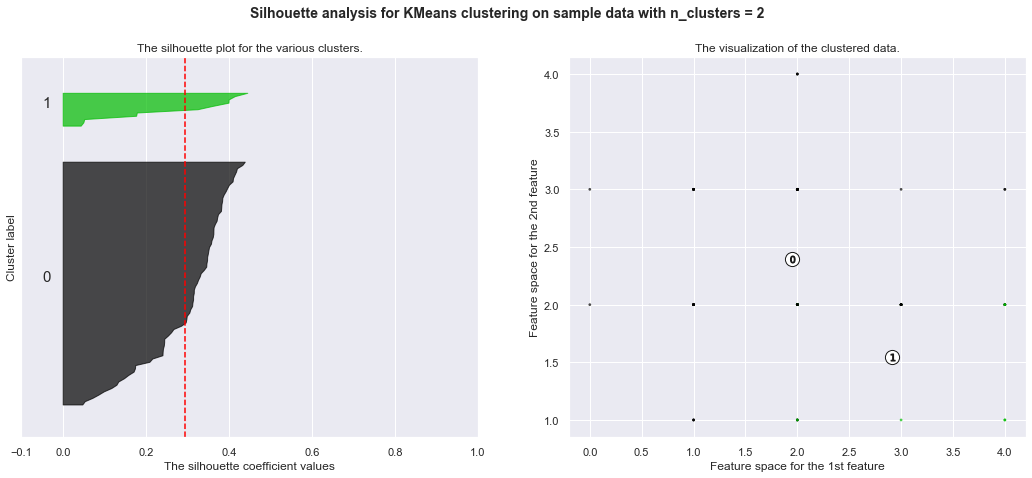

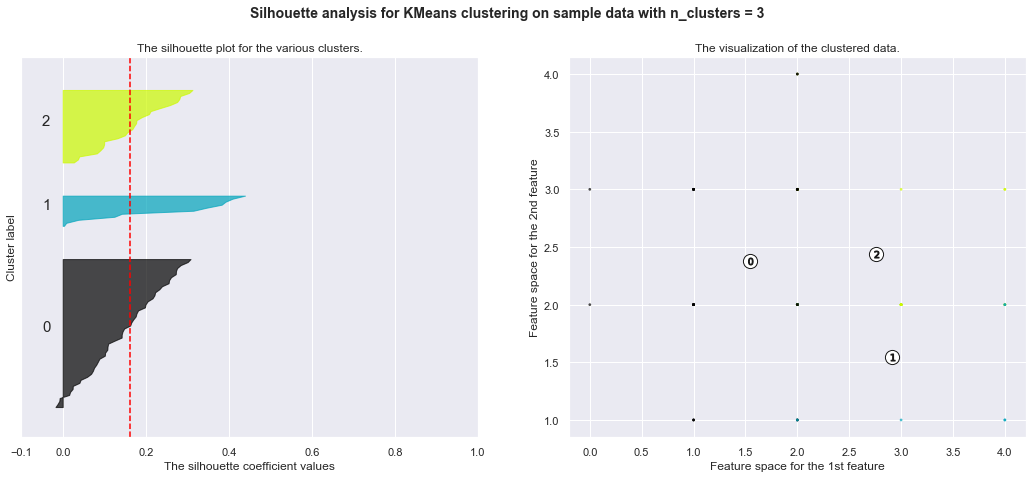

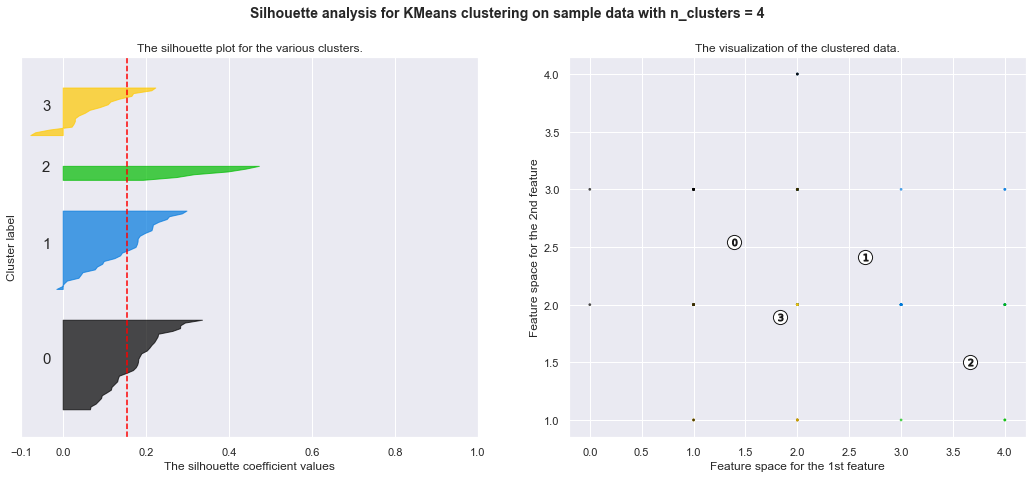

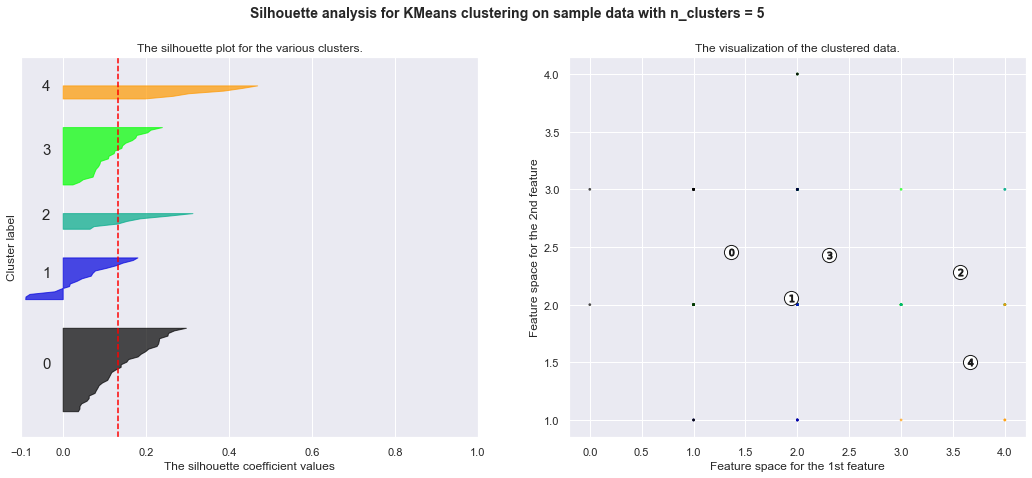

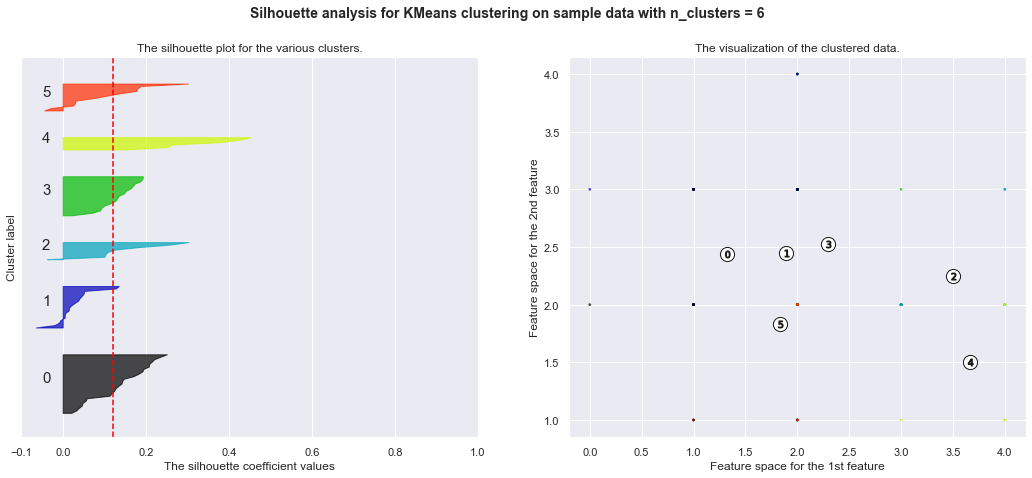

In [19]:
print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(features) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(features[:, 0], features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

<blockquote>
The value of 6 for n_clusters looks to be the optimal one. The silhouette score for each cluster is above average silhouette scores. Also, the fluctuation in size is similar. The thickness of the silhouette plot representing each cluster also is a deciding point. For the plot with n_cluster=6, the thickness is more uniform than the other plots. Thus, one can select the optimal number of clusters as 6. This goes further to show that I've selected the correct number of clusters in my model and therefore the model should be performing well enough. Looking at our coefficient values where a value of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect. The coefficient value is really low, so even though I've selected the optimal number of clusters and the model is performing at the best of it's ability there are still overlapping clusters or clusters that are polluted. But to select any more or any less clusters would not make any logical sense so I'll stick to this amount of clusters as they are the best. Overall regardless of the number of clusters the coefficient scores are low.
    </blockquote>